## 🔹 Etapa 1 – Coleta de Dados
- Arquivos de criminalidade são coletados.
- Listagem e confirmação dos arquivos lidos.

In [99]:

import pandas as pd
import numpy  as np
import unicodedata

arquivos_crime = ["crime.csv", "crime2.csv", "crime3.csv", "crime4.csv", "crime5.csv"]
print("Datasets coletados:", arquivos_crime)


Datasets coletados: ['crime.csv', 'crime2.csv', 'crime3.csv', 'crime4.csv', 'crime5.csv']


## 🔹 Etapa 2 – Concatenação dos Dados de Criminalidade

In [ ]:

df = pd.concat([
    pd.read_csv(f, sep=";", encoding="latin1", low_memory=False)
    for f in arquivos_crime
], ignore_index=True)

print(f"Registros após concatenação: {df.shape[0]} linhas e {df.shape[1]} colunas")


Registros após concatenação: 2768178 linhas e 136 colunas


## 🔹 Etapa 3 – Limpeza e Padronização
- Converte datas para YYYY-MM-DD
- Normaliza categorias
- Preenche valores ausentes

In [100]:
# Função simples para normalizar textos (valores das células)
def normalizar_texto(s):
    return (
        s.astype(str)
         .str.normalize("NFKD")
         .str.encode("ascii", "ignore")
         .str.decode("utf-8")
         .str.strip()
         .str.lower()
         .replace("nan", "nao informado")
         .replace("", "nao informado")
    )

# Normaliza o nome das colunas (cabeçalhos)
df.columns = [
    unicodedata.normalize("NFKD", col)
    .encode("ascii", "ignore")
    .decode("utf-8")
    .lower()
    .replace(" ", "_")
    for col in df.columns
]

# Remove colunas completamente vazias ou inúteis
df = df.dropna(axis=1, how="all")
df = df.loc[:, ~df.columns.str.contains(r"^unnamed|^\.*$", case=False)]

# Filtra somente registros de Passo Fundo
df = df[df["municipio_fato"].str.strip().str.lower() == "passo fundo"]

# Remove duplicatas
df = df.drop_duplicates()

# Converte a coluna de data (se existir)
if "data_fato" in df.columns:
    df["data"] = pd.to_datetime(df.pop("data_fato"), errors="coerce", dayfirst=True)

# Preenche e converte colunas numéricas específicas
df[["quantidade_vitimas", "idade_vitima"]] = (
    df[["quantidade_vitimas", "idade_vitima"]]
    .apply(pd.to_numeric, errors="coerce")
    .fillna(0)
    .astype(int)
)

colunas_texto = df.select_dtypes(include=["object", "string"]).columns
df[colunas_texto] = df[colunas_texto].apply(normalizar_texto)

print(f'Dados limpos, colunas padronizadas e valores normalizados.\nRegistros após Filtros: "{df.shape[0]}" linhas e "{df.shape[1]}" colunas')

Dados limpos, colunas padronizadas e valores normalizados.
Registros após Filtros: "57733" linhas e "13" colunas


## 🔹 Etapa 4 – Integração com Dados Meteorológicos
- Importa clima.csv
- Padroniza e trata nulos
- Faz merge com base na data

In [101]:

clima = pd.read_csv("clima.csv", sep=";", encoding="latin1")
clima.columns = (clima.columns
    .str.normalize('NFKD')
    .str.encode('ascii', errors='ignore')
    .str.decode('utf-8')
    .str.lower()
    .str.replace(r'\W+', '_', regex=True)
    .str.strip('_')
)
clima         = clima.loc[:, ~clima.columns.str.lower().str.contains("unnamed")]
clima["data"] = clima["data"] = pd.to_datetime(clima.pop("data_medicao"), errors="coerce", dayfirst=True)
clima         = clima.sort_values("data").bfill()

df_final = pd.merge(df, clima, on="data", how="left")

# Trata nulos pós-merge
clima_cols = [col for col in clima.columns if col != "data"]
df_final[clima_cols] = df_final[clima_cols].bfill()

print("Dados integrados com sucesso.")


Dados integrados com sucesso.


## 📁 Exportação Final

In [102]:

df_final.to_csv("dataset_unificado.csv", index=False)
print("Dataset salvo como 'dataset_unificado.csv'")
print(f"Total de registros: {df_final.shape[0]} | Colunas: {df_final.shape[1]}")

Dataset salvo como 'dataset_unificado.csv'
Total de registros: 57733 | Colunas: 18


## 🔹 Etapa 5 – Transformações
- Converter categóricas em numéricas
- Tratar outliers (IQR)
- Normalizar e Padronizar

In [103]:
from sklearn.preprocessing import MinMaxScaler

# 🔁 Backup de colunas antes de modificar
df_final["idade_vitima_real"] = df_final["idade_vitima"]
df_final["quantidade_vitimas_real"] = df_final["quantidade_vitimas"]

# 🎯 Converter colunas com poucos valores únicos para categoria
df_final = df_final.apply(
    lambda col: col.astype("category") if col.dtype == "object" and 1 < col.nunique() < 20 else col
)

# 🔎 Remover outliers apenas de colunas desejadas
outlier_report = {}
for col in ["idade_vitima"]:  # só tratamos idade, não mexemos em quantidade_vitimas
    q1, q3 = df_final[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    limite_inf, limite_sup = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = df_final[(df_final[col] < limite_inf) | (df_final[col] > limite_sup)]

    if not outliers.empty:
        outlier_report[col] = {
            "count": len(outliers),
            "percent": round(100 * len(outliers) / len(df_final), 2),
            "min": outliers[col].min(),
            "max": outliers[col].max()
        }
        df_final = df_final[(df_final[col] >= limite_inf) & (df_final[col] <= limite_sup)]

# Normalização com Min-Max (exceto colunas backup)
num_cols = df_final.select_dtypes(include="number").columns
cols_escala = [c for c in num_cols if c not in ["idade_vitima_real", "quantidade_vitimas_real"]]
df_final[cols_escala] = MinMaxScaler().fit_transform(df_final[cols_escala])

# Relatório
print("✅ Dados normalizados com sucesso!")
print(f"🔢 Colunas escaladas: {cols_escala}")
if outlier_report:
    for col, info in outlier_report.items():
        print(f"🚨 {col}: {info['count']} outliers removidos ({info['percent']}%), de {info['min']} a {info['max']}")
else:
    print("🎉 Nenhum outlier detectado.")


✅ Dados normalizados com sucesso!
🔢 Colunas escaladas: ['quantidade_vitimas', 'idade_vitima']
🚨 idade_vitima: 228 outliers removidos (0.39%), de 84 a 104


## 🔹 Etapa 6 – Visualização inicial
1. Ocorrências Criminais por Mês (Série Temporal)

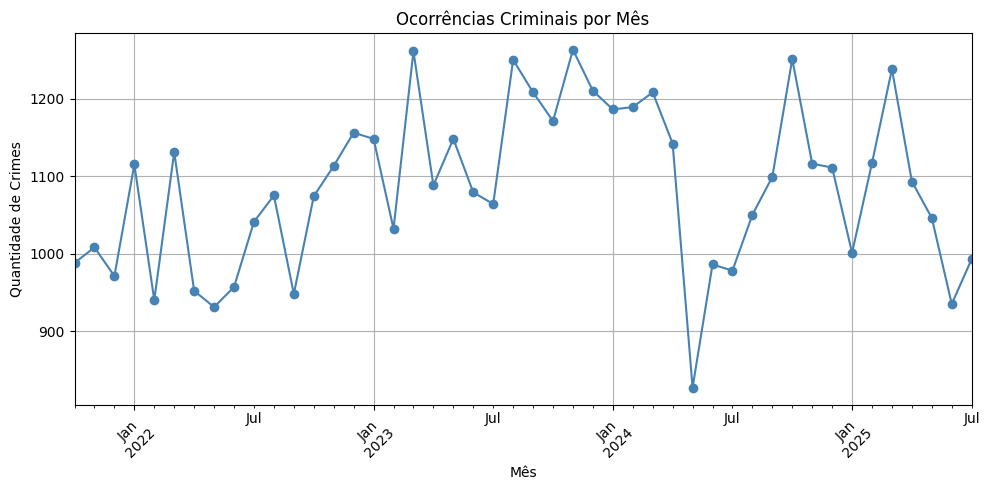

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico 1: Ocorrências Criminais por Mês (série temporal)
df_crimes_mensal = df_final.groupby(df_final["data"].dt.to_period("M")).size()

plt.figure(figsize=(10, 5))
df_crimes_mensal.plot(marker='o', color='steelblue')
plt.title("Ocorrências Criminais por Mês")
plt.xlabel("Mês")
plt.ylabel("Quantidade de Crimes")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


2. Top 10 Bairros com Mais Crimes (Barplot Horizontal)

/tmp/ipython-input-3163053314.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_bairros.values, y=top_bairros.index, palette=["steelblue"])
/tmp/ipython-input-3163053314.py:6: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=top_bairros.values, y=top_bairros.index, palette=["steelblue"])


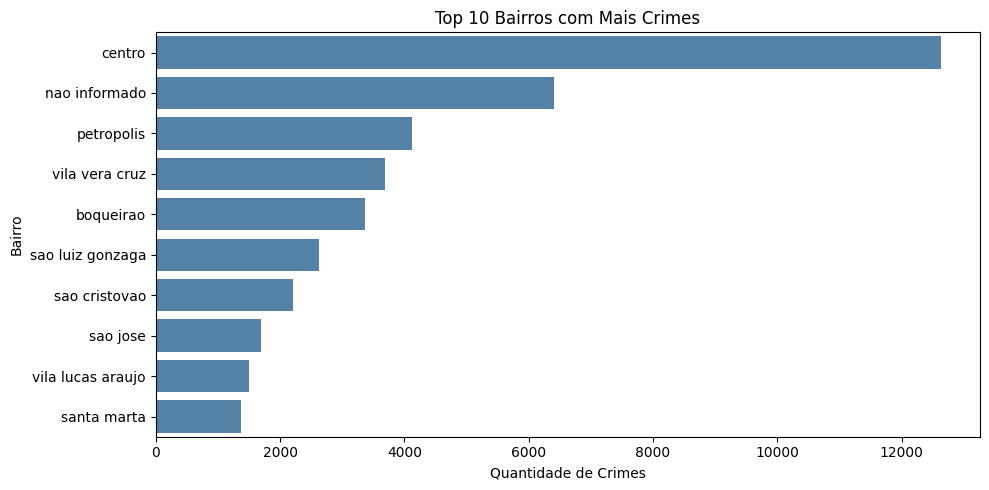

In [105]:
plt.figure(figsize=(10, 5))

# Top 10 bairros
top_bairros = df_final["bairro"].value_counts().head(10)

sns.barplot(x=top_bairros.values, y=top_bairros.index, palette=["steelblue"])
plt.title("Top 10 Bairros com Mais Crimes")
plt.xlabel("Quantidade de Crimes")
plt.ylabel("Bairro")
plt.tight_layout()
plt.show()


3. Idade das Vítimas por Tipo de Enquadramento

/tmp/ipython-input-3112197176.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


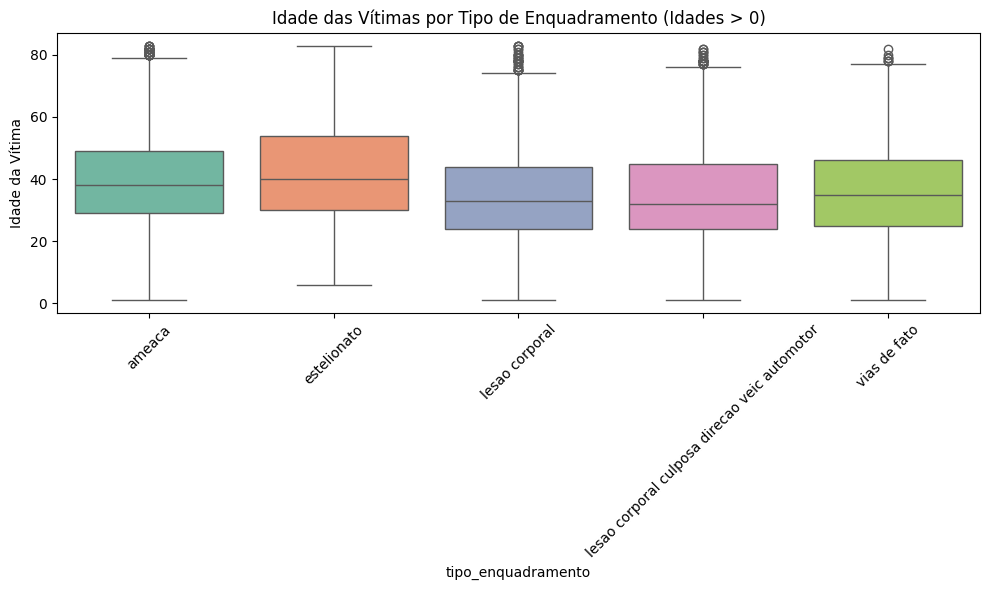

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Garante que a coluna "idade_vitima_real" seja numérica.
# Converte strings inválidas para NaN automaticamente.
df_final["idade_vitima_real"] = pd.to_numeric(df_final["idade_vitima_real"], errors="coerce")

# Remove registros com idade inválida (zero ou superior a 100 anos).
df_final = df_final[(df_final["idade_vitima_real"] > 0) & (df_final["idade_vitima_real"] <= 100)]

# Identifica os 5 tipos de enquadramento com maior número de ocorrências.
top_tipos = df_final["tipo_enquadramento"].value_counts().head(5).index

# Filtra apenas os registros que pertencem a esses 5 tipos.
df_box = df_final[df_final["tipo_enquadramento"].isin(top_tipos)]

plt.figure(figsize=(10, 6))  # Define o tamanho da figura

# Cria o boxplot para visualizar a distribuição da idade das vítimas por tipo de enquadramento
sns.boxplot(
    data=df_box,
    x="tipo_enquadramento",              # Eixo X: tipos de enquadramento
    y="idade_vitima_real",               # Eixo Y: idade das vítimas (já tratada)
    palette="Set2",                      # Paleta de cores suave
    order=top_tipos                      # Mantém a ordem dos 5 mais frequentes
)

# Define o título e ajustes visuais
plt.title("Idade das Vítimas por Tipo de Enquadramento (Idades > 0)")
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo X para melhor leitura
plt.ylabel("Idade da Vítima")
plt.tight_layout()       # Evita que os elementos do gráfico fiquem cortados

# Exibe o gráfico
plt.show()

## 🔹 Etapa 7 – Correlações
- Correlação próxima de 0: sem relação clara.
- Correlação positiva (próx. +1): as variáveis aumentam juntas.
- Correlação negativa (próx. -1): uma aumenta enquanto a outra diminui.


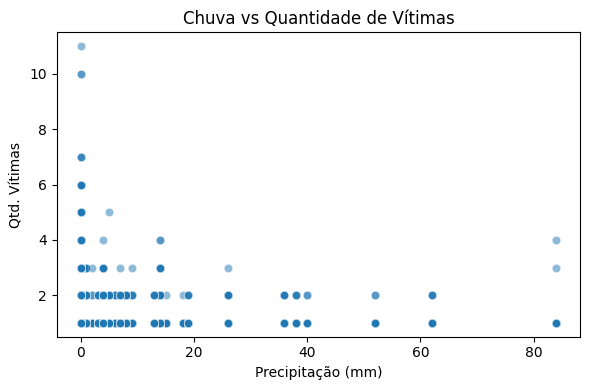

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Converter colunas de clima para numérico (caso estejam como string)
df_final["precipitacao_total_diario_aut_mm"] = pd.to_numeric(df_final["precipitacao_total_diario_aut_mm"], errors="coerce")

# Gráfico de dispersão
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_final, x="precipitacao_total_diario_aut_mm", y="quantidade_vitimas_real", alpha=0.5)
plt.title("Chuva vs Quantidade de Vítimas")
plt.xlabel("Precipitação (mm)")
plt.ylabel("Qtd. Vítimas")
plt.tight_layout()
plt.show()